In [1]:
import sys 

import torch

import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange
from copy import deepcopy
from scipy.stats import gaussian_kde

sys.path.append("../lib")

from sw_sphere import sliced_wasserstein_sphere
from power_spherical import *
from exp_map_nf import create_NF
from utils_sphere import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Utils Sphere

In [3]:
def pdf_vmf(x, mu, kappa):
    return torch.exp(kappa * torch.matmul(mu, x.T))[0]

In [4]:
def pdf_power_spherical(x, mu, kappa):
    return (1+torch.matmul(mu, x.T))**kappa

In [5]:
def sample_power_spherical(mu, kappa, n, dim=3, device=device):
    """
        See https://github.com/nicola-decao/power_spherical for the official implementation
        
        [1] De Cao, Nicola, and Wilker Aziz. "The power spherical distribution." arXiv preprint arXiv:2006.04437 (2020).
    """
    if mu.ndim == 1:
        mu = mu[None]
        
    beta = D.Beta((dim - 1) / 2 + kappa, (dim - 1) / 2)
    e1 = torch.zeros(dim, device=device)
    e1[0] = 1
        
    z = beta.sample((n,))[None].to(device)
    t = 2*z-1
    v = F.normalize(torch.randn(n, dim-1, device=device), p=2, dim=-1)    
    y = torch.cat([t, torch.sqrt(1-t**2) * v.T], dim=0)
    u = F.normalize(e1-mu, p=2, dim=-1)
    
    return torch.matmul((torch.eye(dim, device=device)-2*u.T@u),y).T

In [6]:
mu = torch.tensor([[0,1,0]], dtype=torch.float, device=device)
mu = torch.tensor([0,1,0], dtype=torch.float, device=device)

kappa = 10

V = lambda x : -torch.log(pdf_power_spherical(x, mu, kappa))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

x = sample_power_spherical(mu, kappa, 100)

~/Sphere/SW_Sphere/./lib/utils_sphere.py:84: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


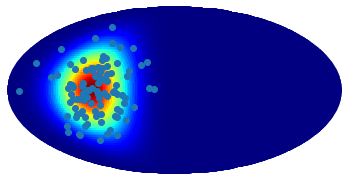

In [7]:
scatter_mollweide(x.detach().cpu(), target)

### GLA

Gradient descent on the sphere:
\begin{equation}
    x_{k+1} = \exp_{x_k}(-\gamma_k \nabla_{S^{d-1}}\mathcal{F}(x_k)),
\end{equation}
where $\exp_x(v)=x\cos(\|v\|) + \frac{v}{\|v\|}\sin(\|v\|)$ and $\mathrm{grad} f(x) = \mathrm{Proj}_x(\nabla f(x)) = \nabla f(x) - \langle x,\nabla f(x)\rangle x$ (projection on the orthogonal space).

See e.g. Chapter 3 of [1] or p27 of [2].

The Geodesic Langevin algorithm introduced in [3] consists at applying the exponential map to the usual ULA at each step, i.e.
\begin{equation}
    x_{k+1} = \exp_{x_k}(-\gamma \nabla f(x_k) + \sqrt{2\gamma}Z),
\end{equation}
where $Z\sim \mathcal{N}(0,I)$. (To check if it is not rather
\begin{equation}
    x_{k+1} = \exp_{x_k}(\mathrm{Proj}_{T_{x_k}M}(-\gamma\nabla f(x_k)+\sqrt{2\gamma}Z)).
\end{equation}

Look also at [4] for another Riemannian Langevin method (where they add a Brownian motion increment after applying $\exp_{x_k}(-\gamma \nabla_{S^{d-1}} F(x_k))$.


[1] Absil, P-A., Robert Mahony, and Rodolphe Sepulchre. Optimization algorithms on matrix manifolds. Princeton University Press, 2009.

[2] Boumal, Nicolas, Pierre-Antoine Absil, and Coralia Cartis. "Global rates of convergence for nonconvex optimization on manifolds." IMA Journal of Numerical Analysis 39.1 (2019): 1-33.

[3] Wang, Xiao, Qi Lei, and Ioannis Panageas. "Fast convergence of langevin dynamics on manifold: Geodesics meet log-sobolev." Advances in Neural Information Processing Systems 33 (2020): 18894-18904.

[4] Li, Mufan Bill, and Murat A. Erdogdu. "Riemannian langevin algorithm for solving semidefinite programs." arXiv preprint arXiv:2010.11176 (2020).

In [8]:
def ULA_sphere(V, n_particles=1000, d=2, dt=1e-3, n_steps=4000, device=device, 
               init_distr=None, init_particles=None, bar=False):
    normal = D.MultivariateNormal(torch.zeros(d, device=device),torch.eye(d, device=device))

    if init_particles is None:
        x0 = normal.sample((n_particles,))
        x0 = F.normalize(x0, p=2, dim=-1) ## unif on sphere
    else:
        x0 = init_particles
        
    xk = x0.clone()
    
    L = [x0.clone().detach().cpu()]
    
    if bar:
        pbar = trange(n_steps)
    else:
        pbar = range(n_steps)
    
    for k in pbar:
        xk.requires_grad_(True)
        grad_V = torch.autograd.grad(V(xk).sum(), xk)[0]
        W = normal.sample((n_particles,))
        xk = xk.detach()
        
        v = -grad_V*dt+np.sqrt(2*dt)*W
        v = v - torch.sum(v*xk, axis=-1)[:,None] * xk ## projection on the Tangent space
        norm_v = torch.linalg.norm(v, axis=-1)[:,None]

        xk = xk*torch.cos(norm_v) + torch.sin(norm_v) * v/norm_v

        
        L.append(xk.clone().detach().cpu())
    
    return xk, L

#### vMF

~/Sphere/SW_Sphere/./lib/utils_sphere.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


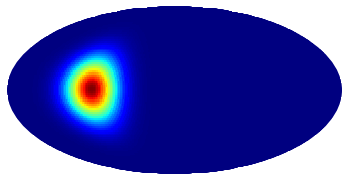

In [9]:
mu = torch.tensor([[0,1,0]], dtype=torch.float, device=device)
kappa = 10

V = lambda x : -torch.log(pdf_vmf(x, mu, kappa))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

plot_target_density(target)

In [10]:
x, L = ULA_sphere(V, bar=True, device=device, d=3, n_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

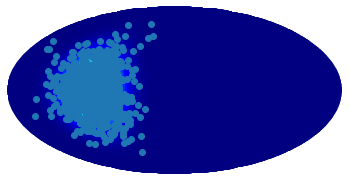

In [11]:
scatter_mollweide(x.detach().cpu(), target)

#### Power-Spherical

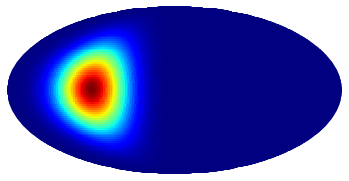

In [12]:
mu = torch.tensor([[0,1,0]], dtype=torch.float, device=device)
kappa = 10

V = lambda x : -torch.log(pdf_power_spherical(x, mu, kappa))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

plot_target_density(target)

In [13]:
x, L = ULA_sphere(V, bar=True, device=device, d=3, n_steps=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

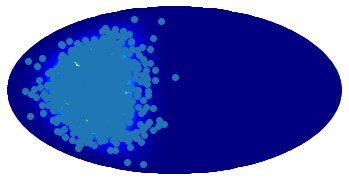

In [14]:
scatter_mollweide(x.detach().cpu(), target)

### SWVI

####  Power Spherical Target

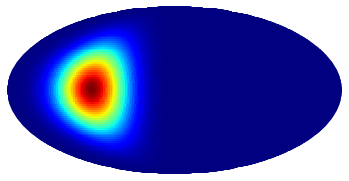

In [15]:
mu = torch.tensor([0,1,0], dtype=torch.float, device=device)
kappa = torch.tensor(10, device=device)

ps = PowerSpherical(mu, kappa)

V = lambda x : -ps.log_prob(x)
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

plot_target_density(target)

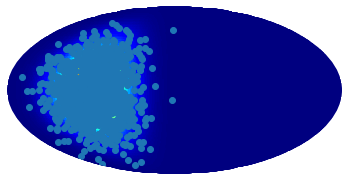

In [16]:
x_ps = ps.sample((1000,))

scatter_mollweide(x_ps.detach().cpu(), target)

In [17]:
def swvi_power_spherical(n_epochs, V, lr, d=3, n_particles=100, steps_mcmc=20, 
                         dt_mcmc=1e-3, n_projs=1000, device=device, plot=False):
    pbar = trange(n_epochs)
    
    L_m = []
    L_kappa = []
    
    kappa = torch.tensor(0.1, device=device, requires_grad=True)
    m = F.normalize(torch.ones(d, device=device, requires_grad=True), p=2, dim=-1)
    
    for e in pbar:
        ps = PowerSpherical(m, kappa)
        z0 = ps.rsample((n_particles,))
        zt, _ = ULA_sphere(V, device=device, init_particles=z0, d=d,
                           n_steps=steps_mcmc, n_particles=z0.shape[0], dt=dt_mcmc)
        
        ## grad descent on sw
        sw = sliced_wasserstein_sphere(z0, zt, num_projections=n_projs, device=device, p=2)/2
        
        if m.requires_grad:
            m_grad = torch.autograd.grad(sw, m, retain_graph=True)[0]
#             m = m - lr*m_grad
#             m = F.normalize(m, p=2, dim=-1)
            
            ## Gradient descent on sphere
            grad_S = m_grad - torch.sum(m*m_grad, dim=-1)*m
            v = -lr*grad_S
            norm_v = torch.linalg.norm(v, axis=-1)
            m = m*torch.cos(norm_v) + torch.sin(norm_v) * v/norm_v

        if kappa.requires_grad:
            ## need other parameterization to be still SPD + gradient descent over manifold
            k_grad = torch.autograd.grad(sw, kappa)[0]
            kappa = kappa - 100*lr*k_grad
            
        if plot and e%200 == 0:
            target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())
            scatter_mollweide(z0.detach().cpu(), target)
            
            print("k="+str(e),m, kappa)
            L_m.append(m.detach().cpu().numpy())
            L_kappa.append(kappa.item())
                
    return m.detach(), kappa.detach(), L_m, L_kappa

  0%|          | 0/2001 [00:00<?, ?it/s]

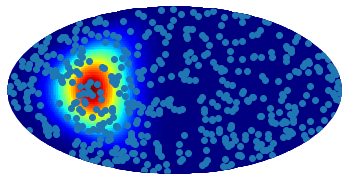

k=0 tensor([0.5767, 0.5784, 0.5770], device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4973, device='cuda:0', grad_fn=<SubBackward0>)


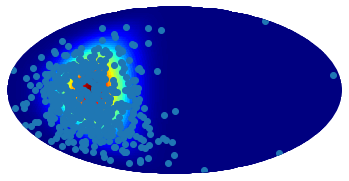

k=200 tensor([0.1964, 0.9616, 0.1915], device='cuda:0', grad_fn=<AddBackward0>) tensor(6.1579, device='cuda:0', grad_fn=<SubBackward0>)


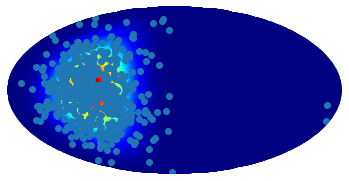

k=400 tensor([0.0502, 0.9967, 0.0634], device='cuda:0', grad_fn=<AddBackward0>) tensor(7.5066, device='cuda:0', grad_fn=<SubBackward0>)


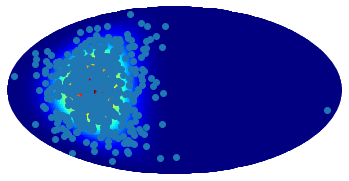

k=600 tensor([0.0151, 0.9998, 0.0138], device='cuda:0', grad_fn=<AddBackward0>) tensor(8.2346, device='cuda:0', grad_fn=<SubBackward0>)


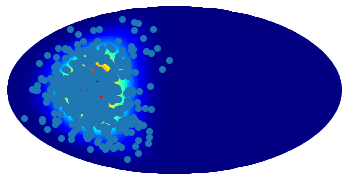

k=800 tensor([0.0050, 0.9999, 0.0101], device='cuda:0', grad_fn=<AddBackward0>) tensor(8.6683, device='cuda:0', grad_fn=<SubBackward0>)


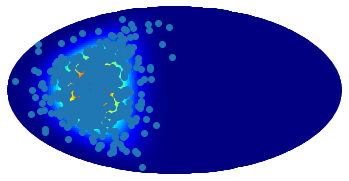

k=1000 tensor([0.0092, 1.0000, 0.0027], device='cuda:0', grad_fn=<AddBackward0>) tensor(9.0400, device='cuda:0', grad_fn=<SubBackward0>)


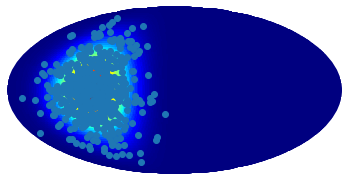

k=1200 tensor([4.3824e-03, 9.9999e-01, 2.8933e-04], device='cuda:0',
       grad_fn=<AddBackward0>) tensor(9.3383, device='cuda:0', grad_fn=<SubBackward0>)


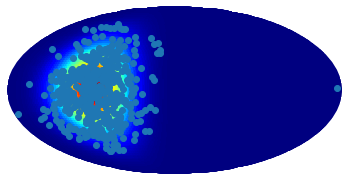

k=1400 tensor([-0.0025,  1.0000,  0.0044], device='cuda:0', grad_fn=<AddBackward0>) tensor(9.4896, device='cuda:0', grad_fn=<SubBackward0>)


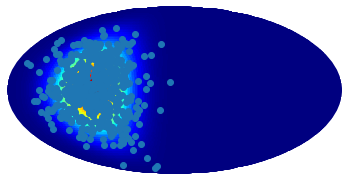

k=1600 tensor([-0.0059,  1.0000,  0.0060], device='cuda:0', grad_fn=<AddBackward0>) tensor(9.6331, device='cuda:0', grad_fn=<SubBackward0>)


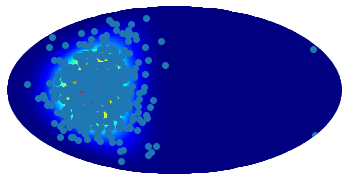

k=1800 tensor([-0.0052,  1.0000, -0.0022], device='cuda:0', grad_fn=<AddBackward0>) tensor(9.7460, device='cuda:0', grad_fn=<SubBackward0>)


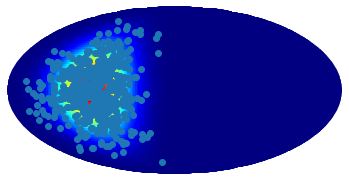

k=2000 tensor([0.0043, 1.0000, 0.0030], device='cuda:0', grad_fn=<AddBackward0>) tensor(9.8232, device='cuda:0', grad_fn=<SubBackward0>)


In [18]:
m, k, Lm, Lk = swvi_power_spherical(2001, V, 2, plot=True, n_particles=500)

~/Sphere/SW_Sphere/./lib/utils_sphere.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet,vmax=vmax)


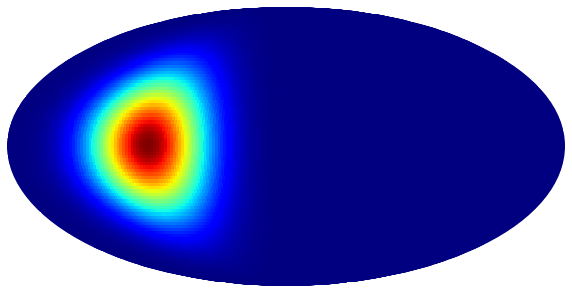

In [19]:
mu = torch.tensor([0,1,0], dtype=torch.float, device=device)
kappa = torch.tensor(10, device=device)

ps = PowerSpherical(mu, kappa)

V = lambda x : -ps.log_prob(x)
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())
maxi = target(spherical_to_euclidean(tp)).max()

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(target, ax, maxi)
plt.show()

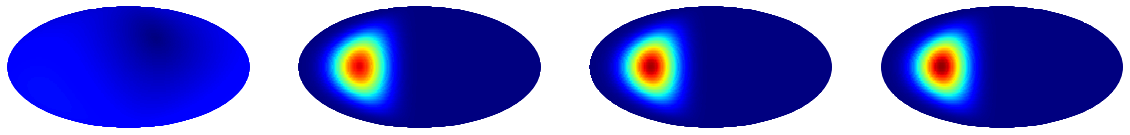

In [20]:
fig, axes = plt.subplots(1, 4, figsize=(20,15), subplot_kw={'projection': "mollweide"}) #, projection="mollweide")

for ind, i in enumerate([0,5,8,10]):
    mu_i = torch.tensor(Lm[i])
    kappa_i = torch.tensor(Lk[i])
    ps = PowerSpherical(mu_i, kappa_i)
    
    V = lambda x : -ps.log_prob(x)
    target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float)).cpu().numpy())
    
    projection_mollweide(target, axes[ind], maxi)

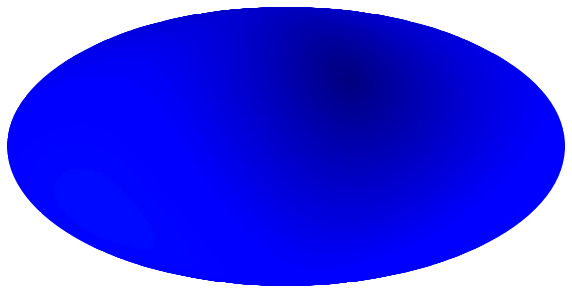

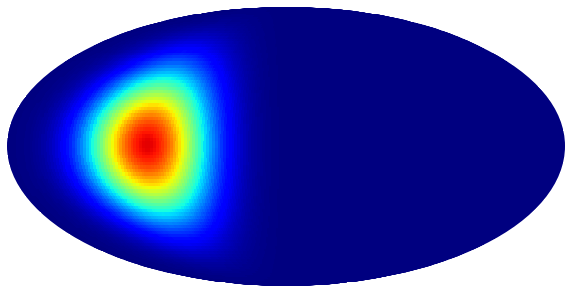

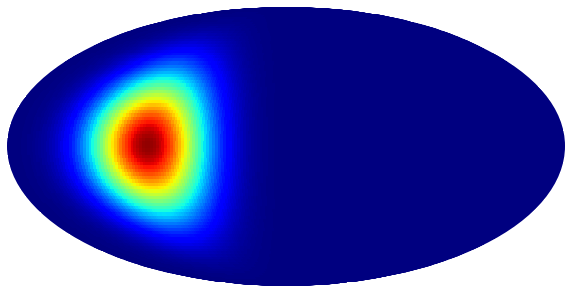

In [21]:
for ind, i in enumerate([0,5,10]):
    mu_i = torch.tensor(Lm[i])
    kappa_i = torch.tensor(Lk[i])
    ps = PowerSpherical(mu_i, kappa_i)
    
    V = lambda x : -ps.log_prob(x)
    target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float)).cpu().numpy())
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
    projection_mollweide(target, ax, maxi)
    plt.show()

#### Mixture of vMF Target + NF

In [32]:
def kl_ess(log_model_prob, target_prob):
    weights = target_prob / np.exp(log_model_prob)
    Z = np.mean(weights)
    KL = np.mean(log_model_prob - np.log(target_prob)) + np.log(Z)
    ESS = np.sum(weights) ** 2 / np.sum(weights ** 2)
    return Z, KL, ESS

In [33]:
def swsvi_nf(n_epochs, V, lr, model=None, d=3, n_particles=100, steps_mcmc=20, 
            dt_mcmc=1e-3, n_projs=1000, device=device, plot=False):
    pbar = trange(n_epochs)
    
    L = []
    
    if model is None:
        model = create_NF(d).to(device)
        
    L.append(deepcopy(model))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for e in pbar:
        optimizer.zero_grad()
        
        noise = F.normalize(torch.randn((n_particles,d), device=device), p=2, dim=-1)
        z0, _ = model(noise)
        zt, _ = ULA_sphere(V, device=device, init_particles=z0[-1], d=d,
                           n_steps=steps_mcmc, n_particles=z0[-1].shape[0], dt=dt_mcmc)
        
        ## grad descent on sw
        sw = sliced_wasserstein_sphere(z0[-1], zt, num_projections=n_projs, device=device, p=2)/2
        sw.backward()
        optimizer.step()
        
#         L_loss = [sw.item()]

        
#         for k in range(10):
#             optimizer.zero_grad()
        
#             noise = F.normalize(torch.randn((n_particles,d), device=device), p=2, dim=-1)
#             z0, _ = model(noise)
#             sw = sliced_wasserstein_sphere(z0[-1], zt, num_projections=n_projs, device=device, p=2)/2
#             sw.backward()
#             optimizer.step()
            
#             L_loss.append(sw.item())
            
#         plt.plot(L_loss)
#         plt.title("Epoch "+str(e))
#         plt.show()
        
            
        if plot and e%100 == 0:
            print("k="+str(e))
            target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())
            
            noise = F.normalize(torch.randn((n_particles,d), device=device), p=2, dim=-1)
            z0, _ = model(noise)
            
            scatter_mollweide(z0[-1].detach().cpu(), target)
            scatter_mollweide(zt.detach().cpu(), target)
            
            kernel = gaussian_kde(z0[-1].T.detach().cpu())
            plot_target_density(lambda x: kernel.pdf(x.T))
            
        if e%100 == 0:
            L.append(deepcopy(model))
                
    return model, L

In [34]:
mus = torch.tensor([[1.5, 0.7+np.pi/2], [1, -1+np.pi/2], [5, 0.6+np.pi/2], [4, -0.7+np.pi/2]], device=device)
target_mus = spherical_to_euclidean_torch(mus)

def target_density(x):
    m = torch.matmul(x, target_mus.T)
    return torch.sum(torch.exp(10 * m), dim=-1)

target_mu = spherical_to_euclidean(np.array([
    [1.5, 0.7 + np.pi / 2],
    [1., -1. + np.pi / 2],
    [5., 0.6 + np.pi / 2],  # 0.5 -> 5.!
    [4., -0.7 + np.pi / 2]
]))

def s2_target(x):
    xe = np.dot(x, target_mu.T)
    return np.sum(np.exp(10 * xe), axis=1)

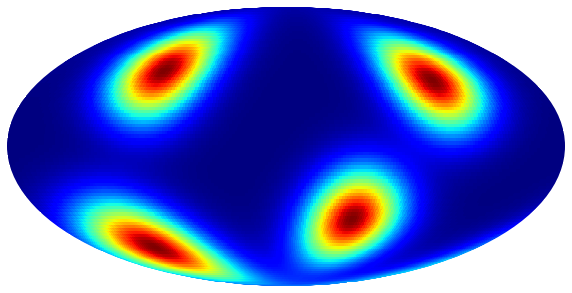

In [35]:
V = lambda x: -torch.log(target_density(x))
target = lambda x : np.exp(-V(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy())

fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(target, ax)
plt.show()

In [41]:
V = lambda x: -torch.log(target_density(x))

model, L = swsvi_nf(10001, V, 1e-3, plot=False, n_particles=500, dt_mcmc=1e-1)

  0%|          | 0/10001 [00:00<?, ?it/s]

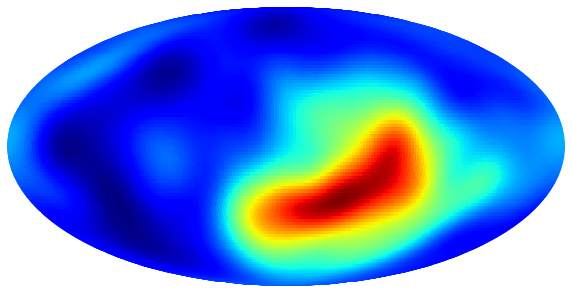

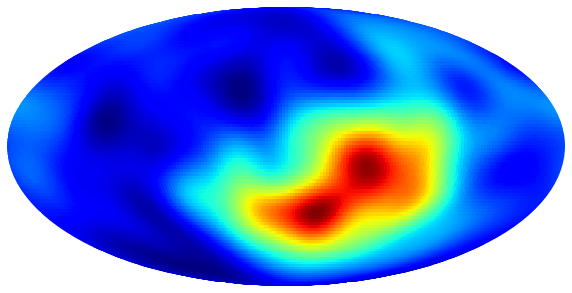

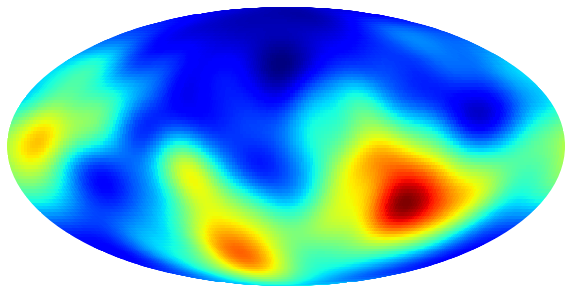

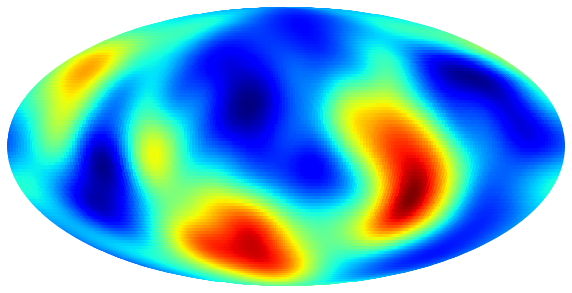

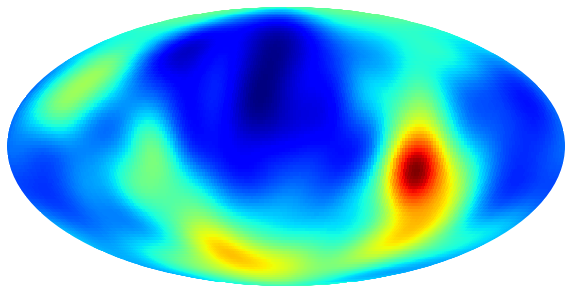

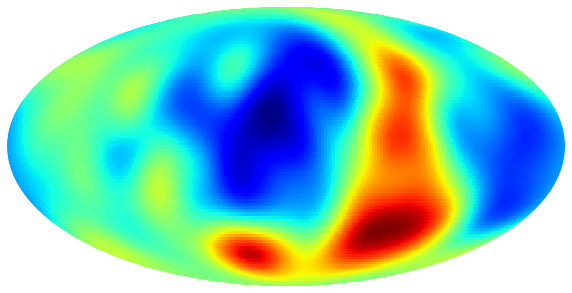

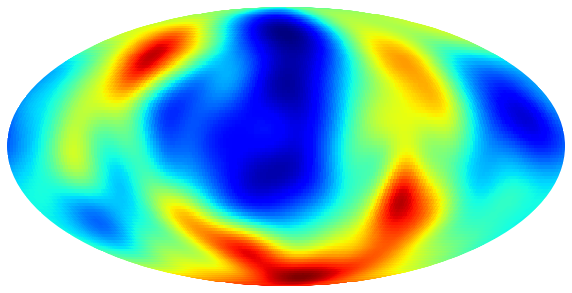

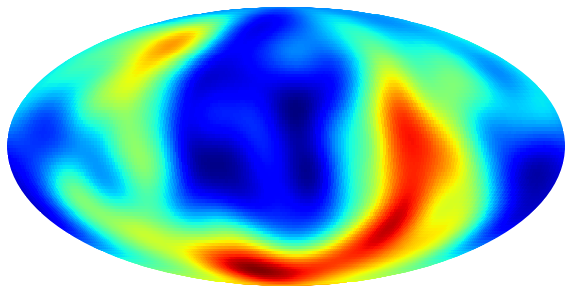

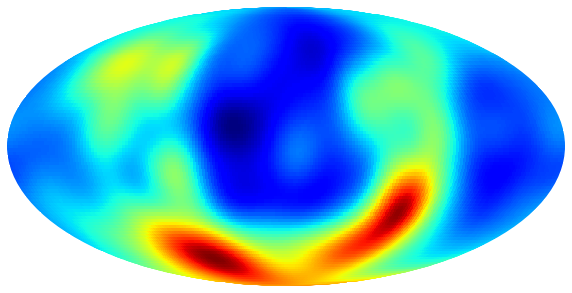

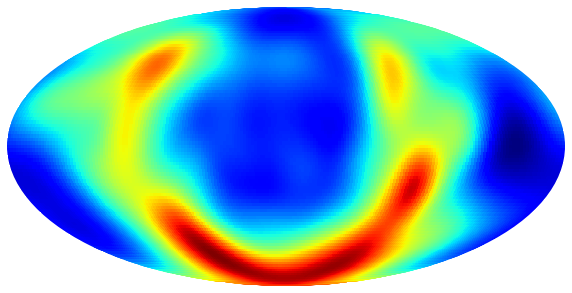

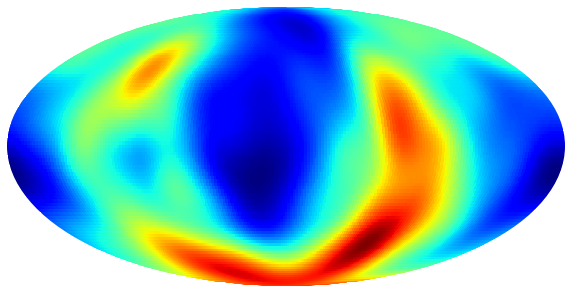

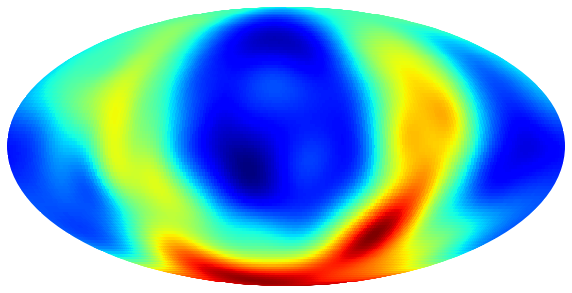

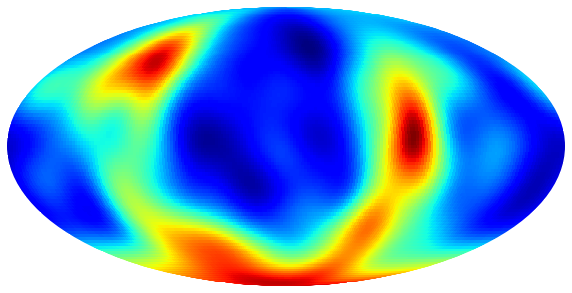

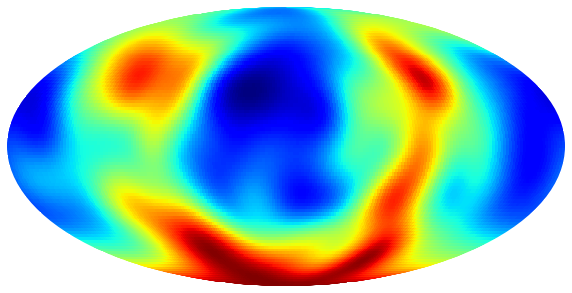

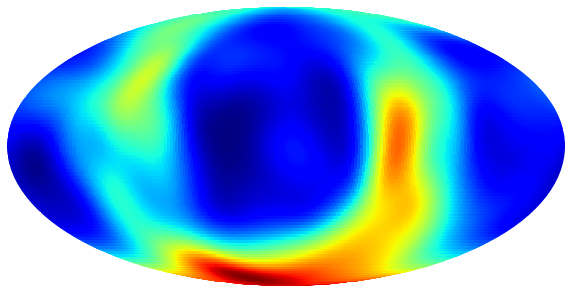

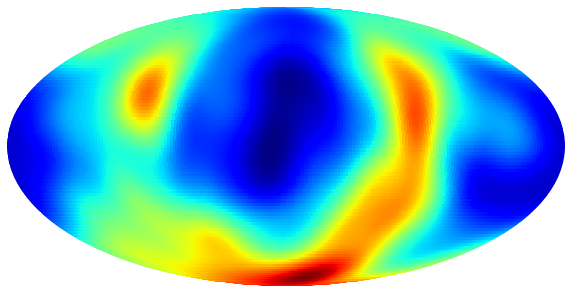

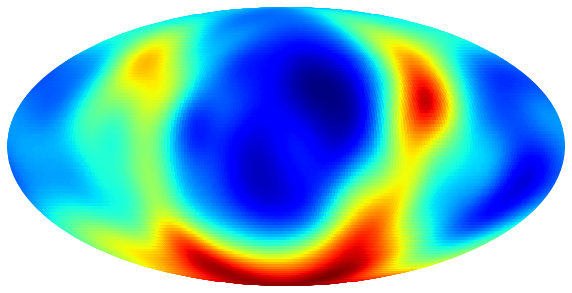

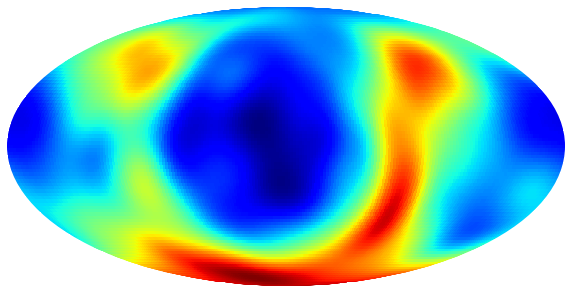

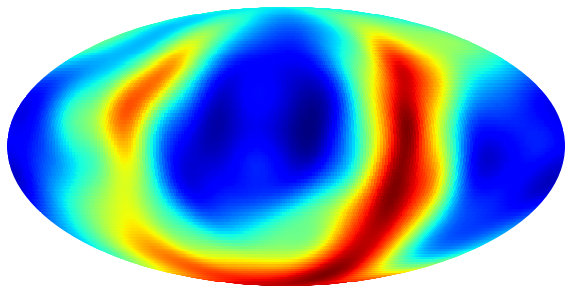

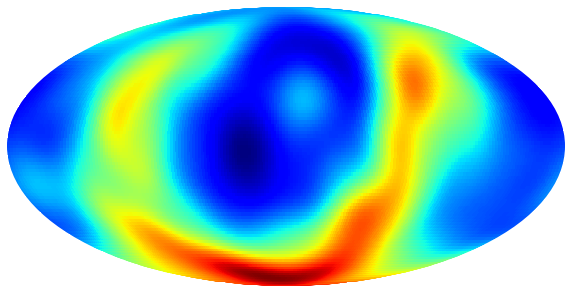

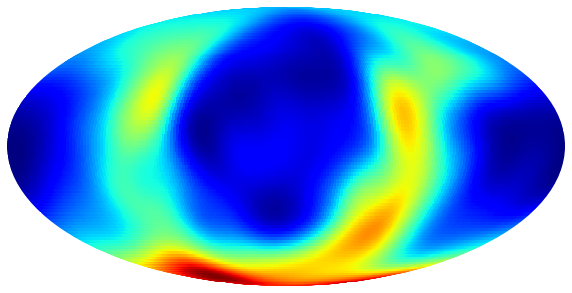

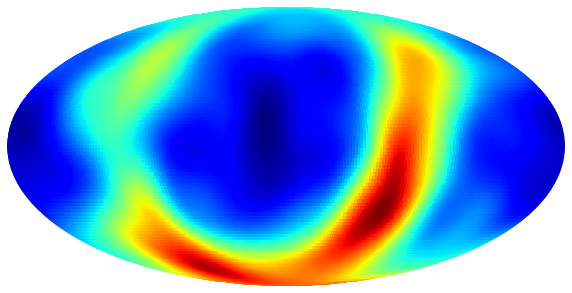

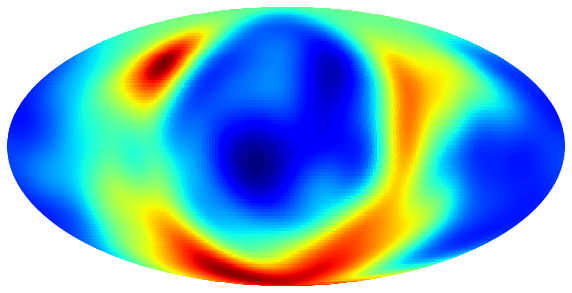

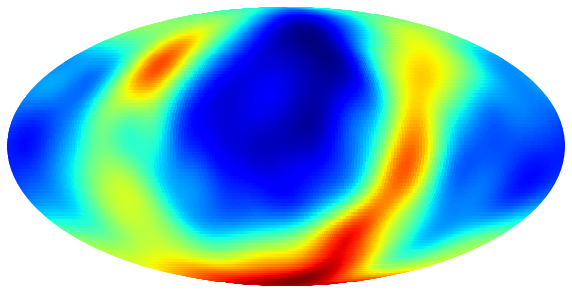

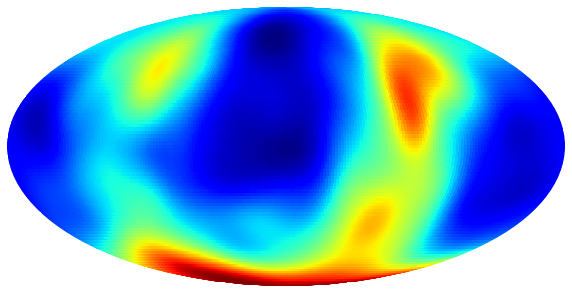

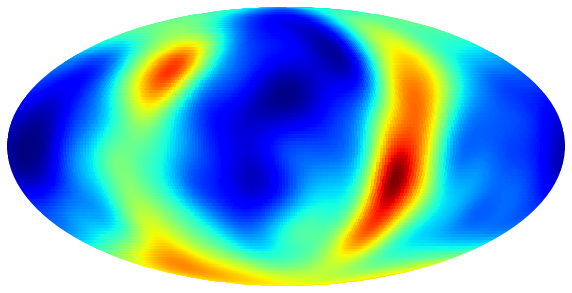

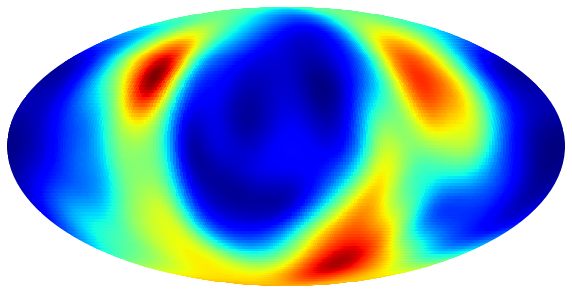

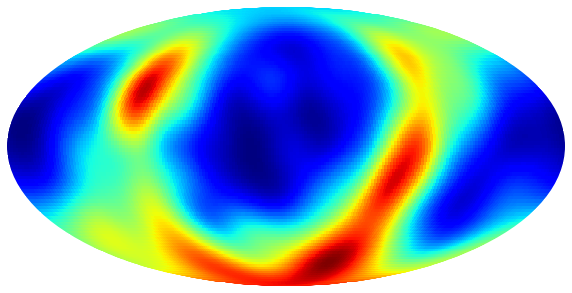

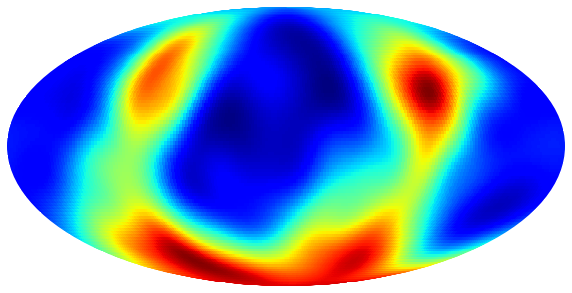

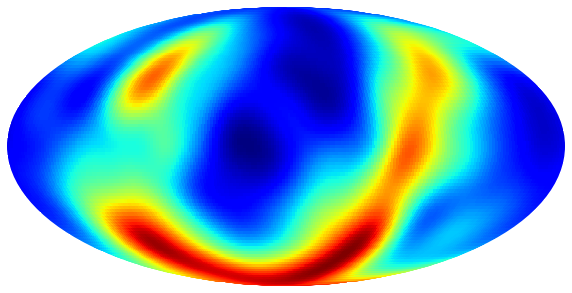

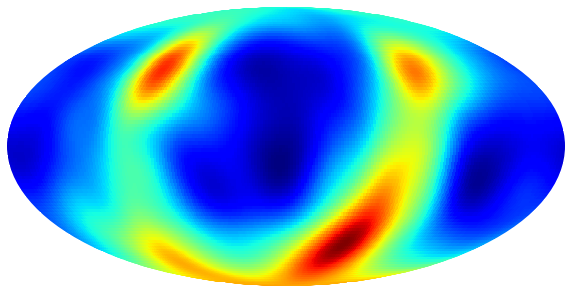

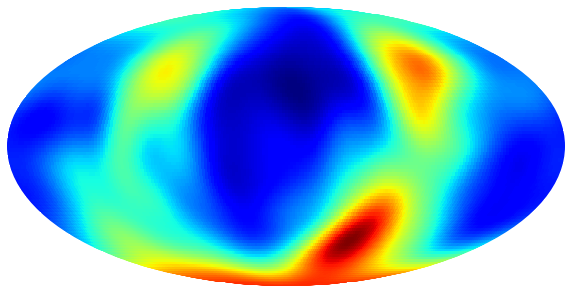

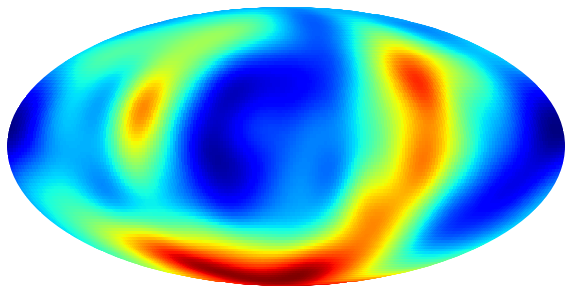

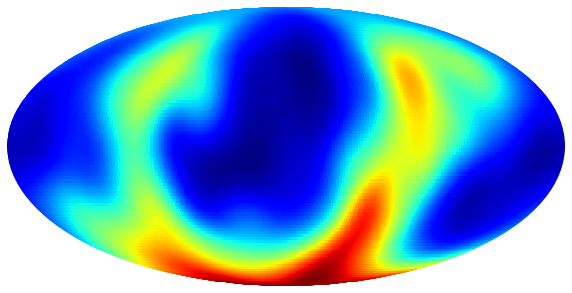

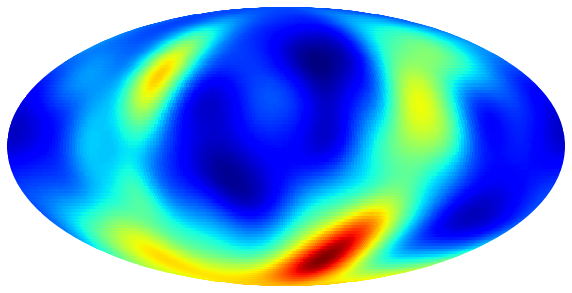

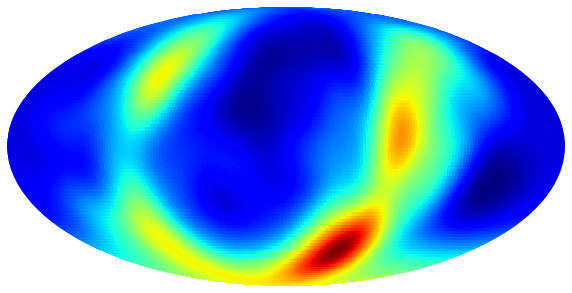

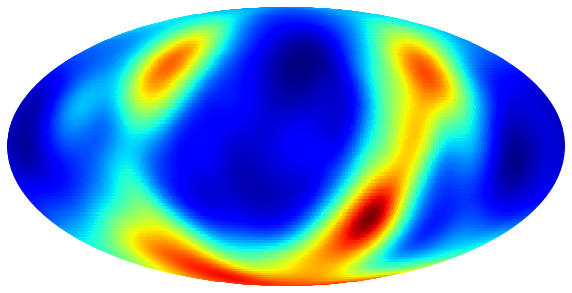

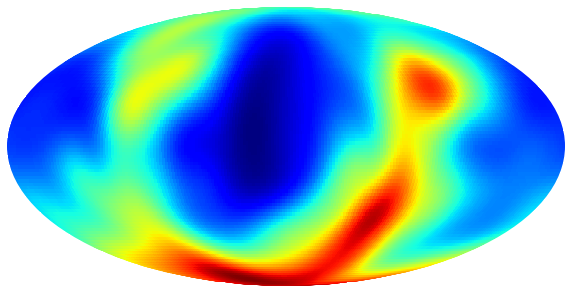

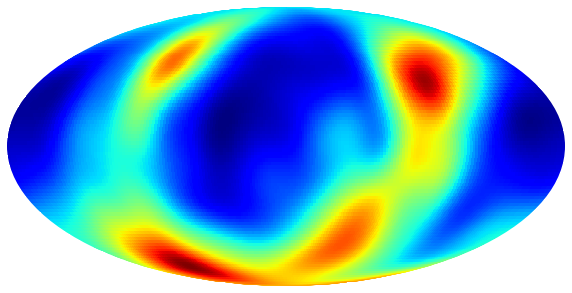

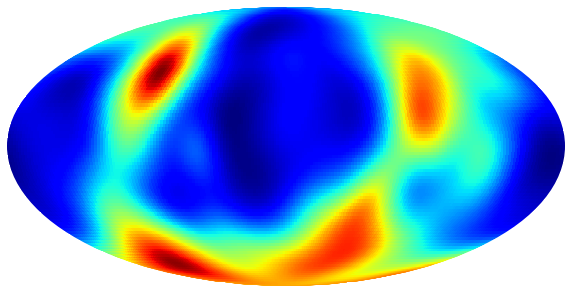

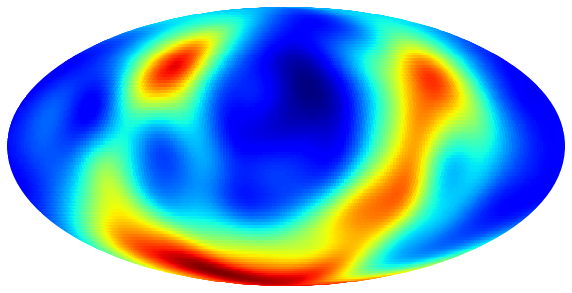

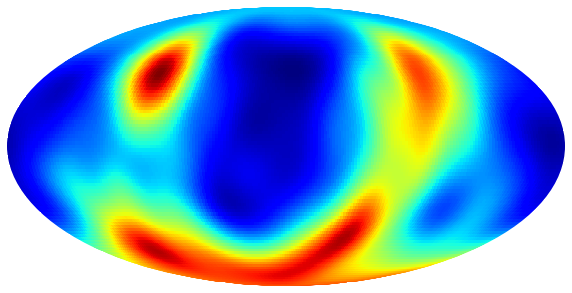

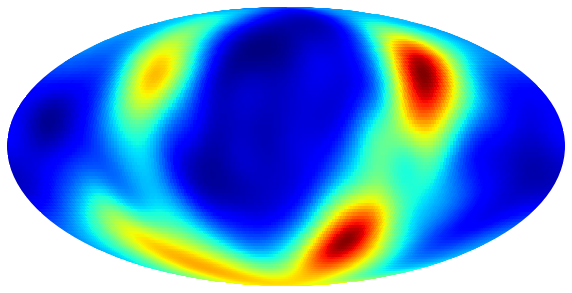

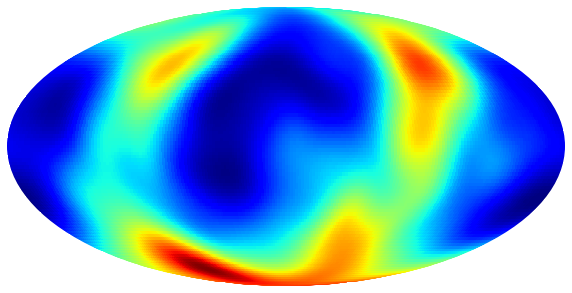

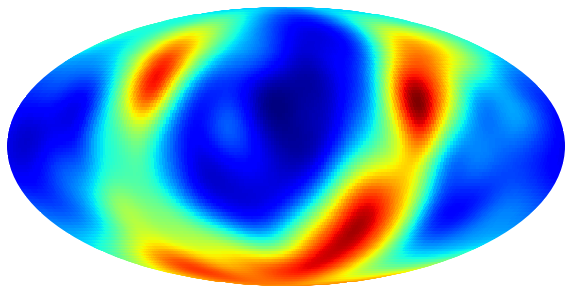

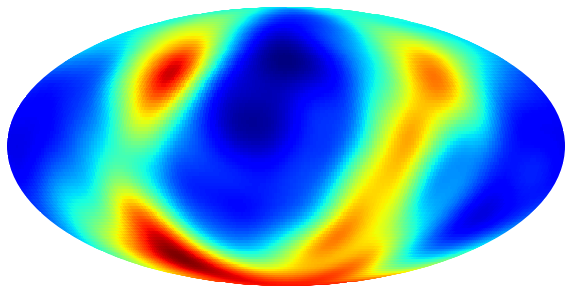

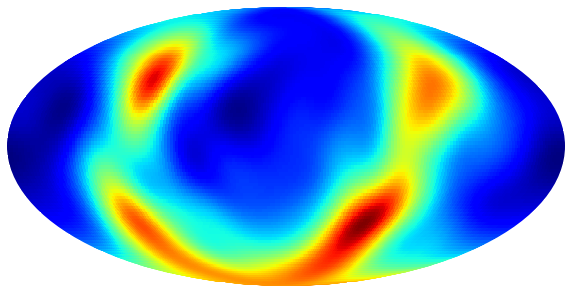

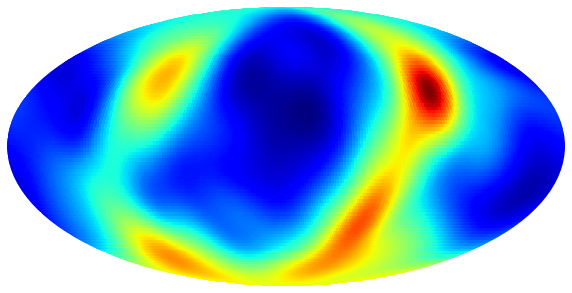

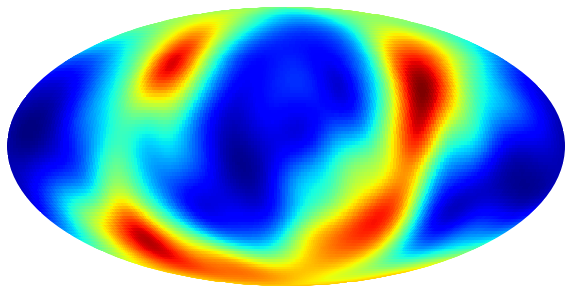

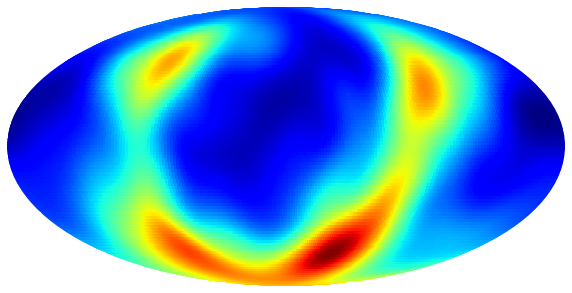

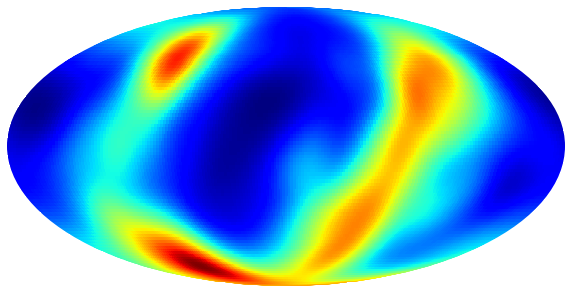

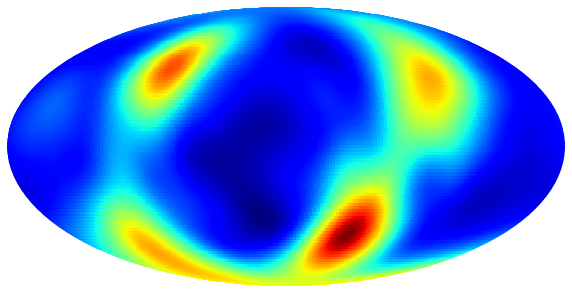

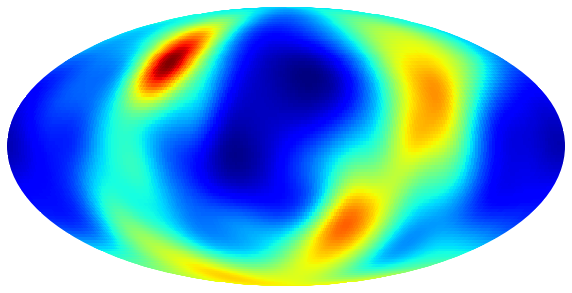

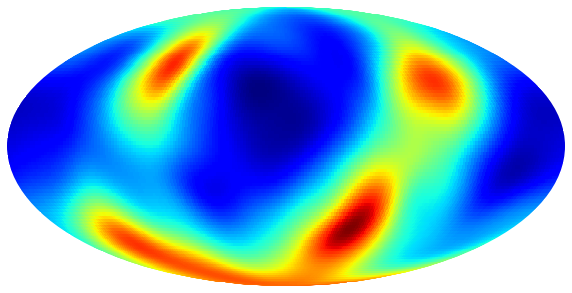

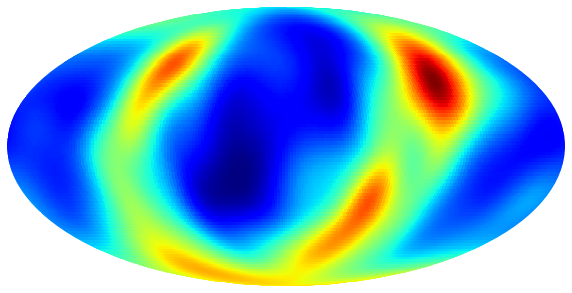

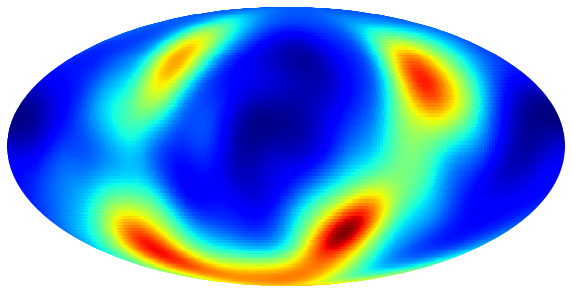

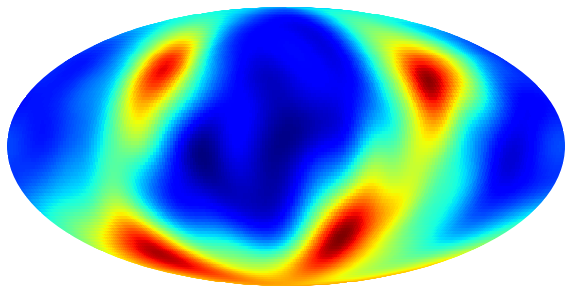

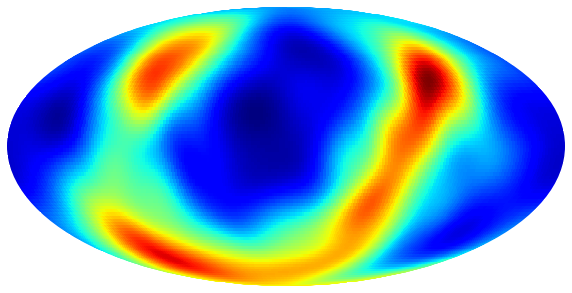

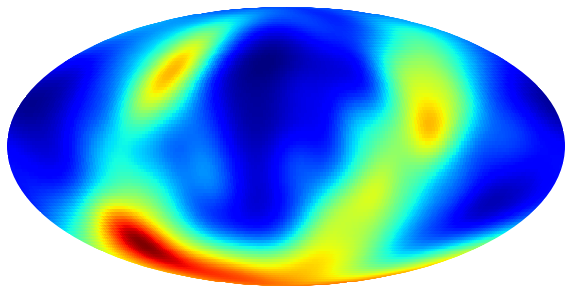

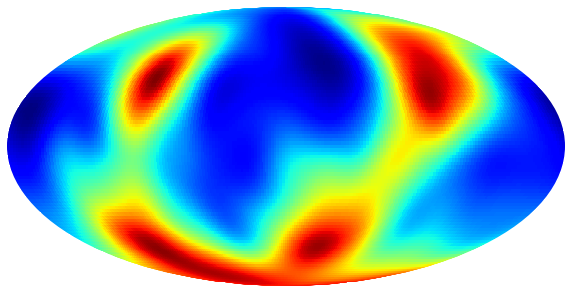

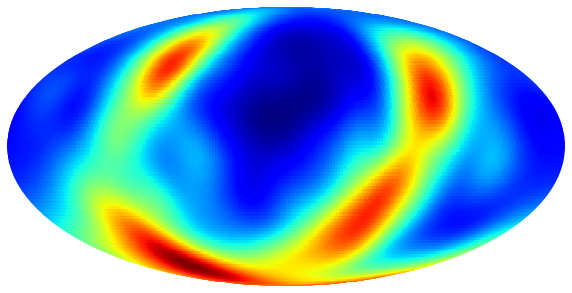

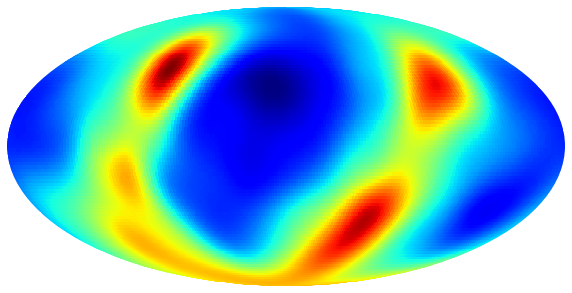

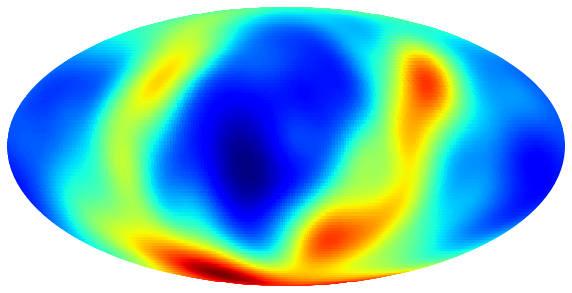

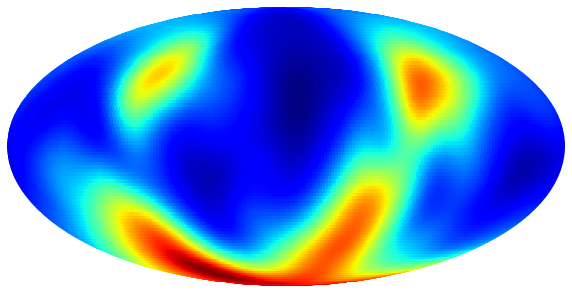

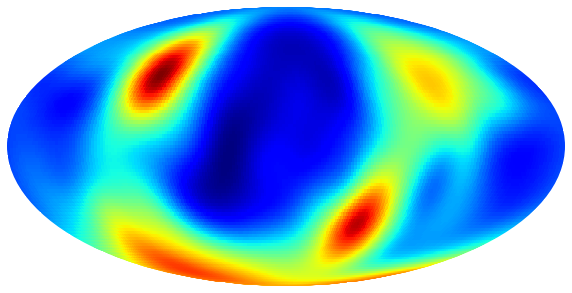

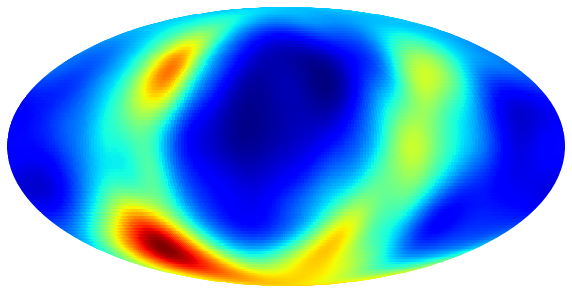

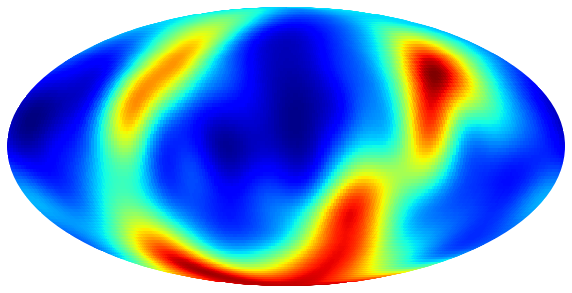

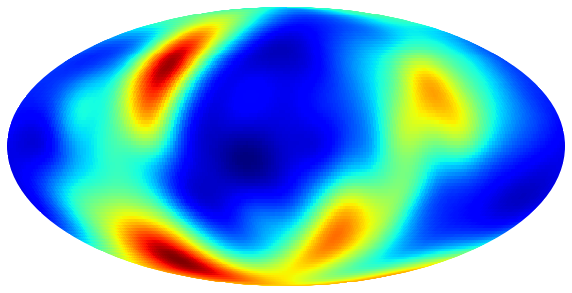

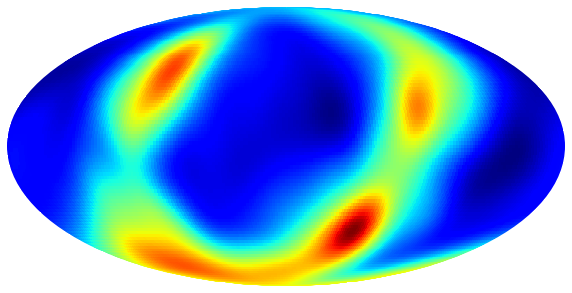

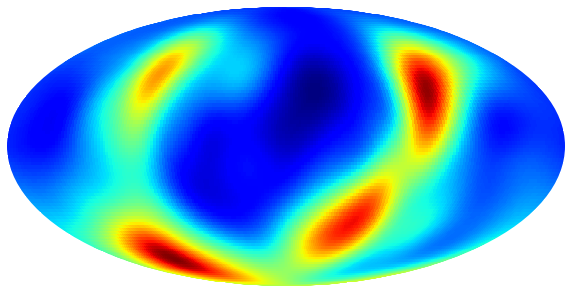

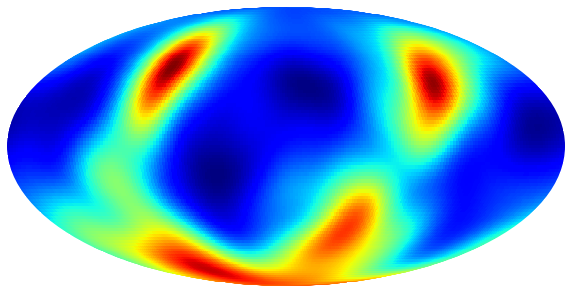

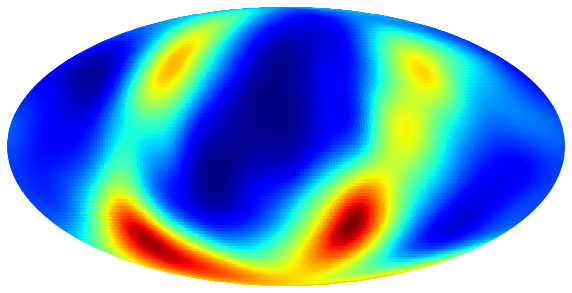

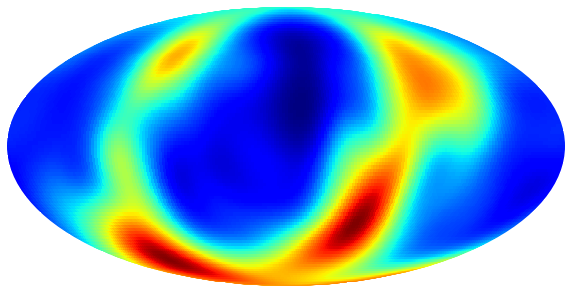

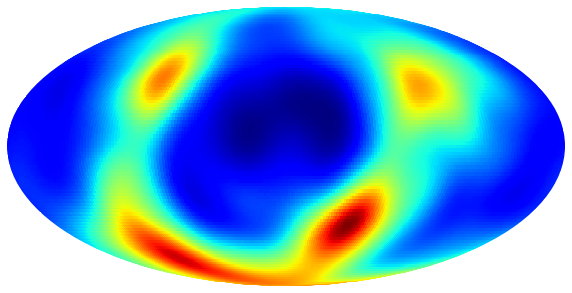

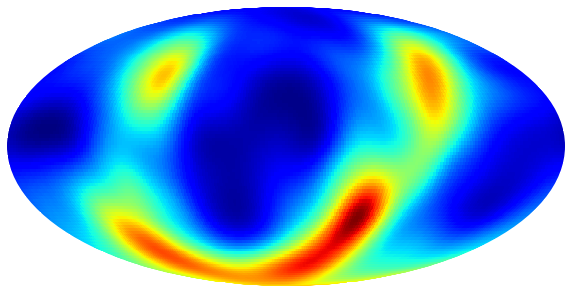

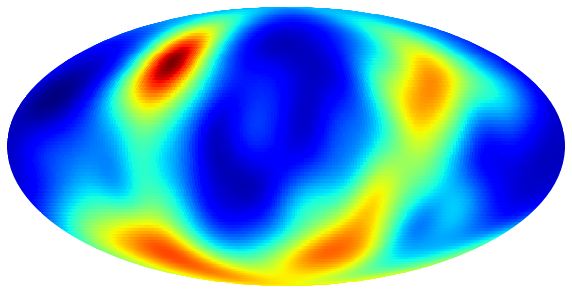

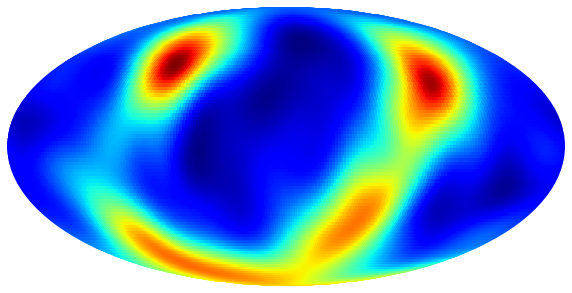

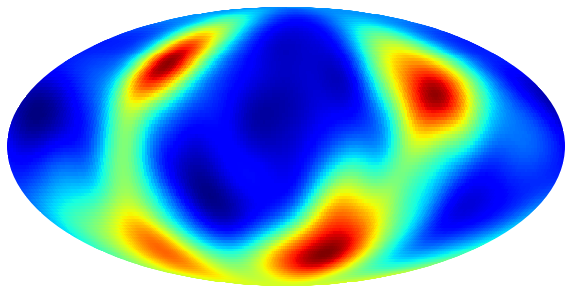

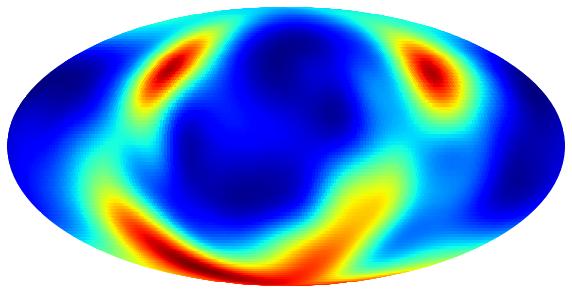

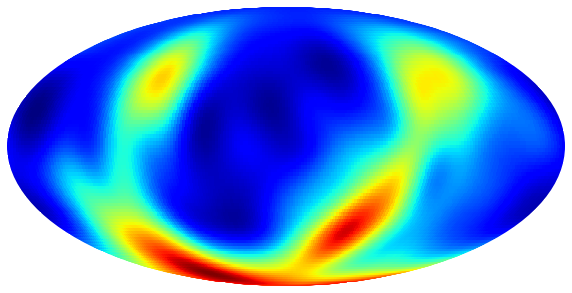

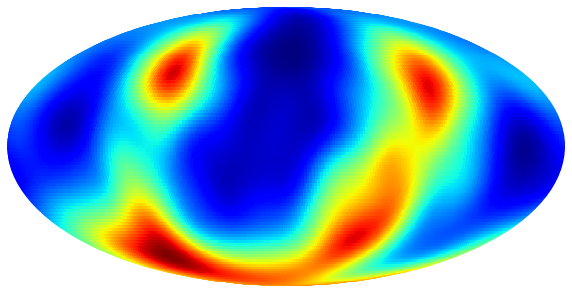

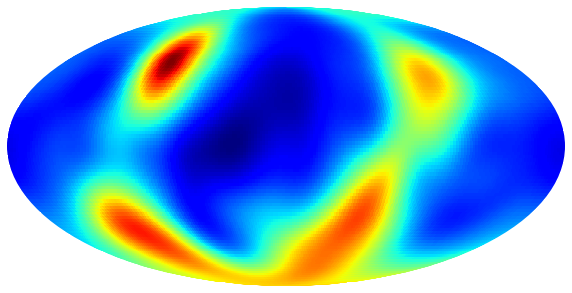

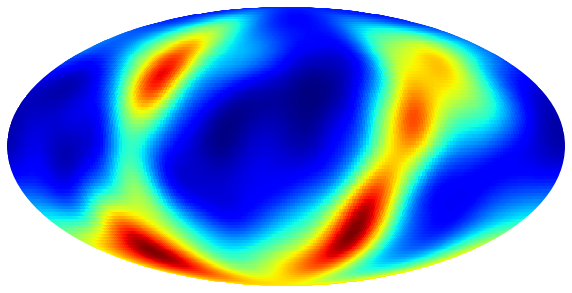

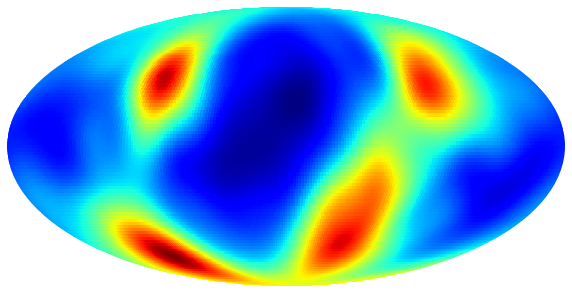

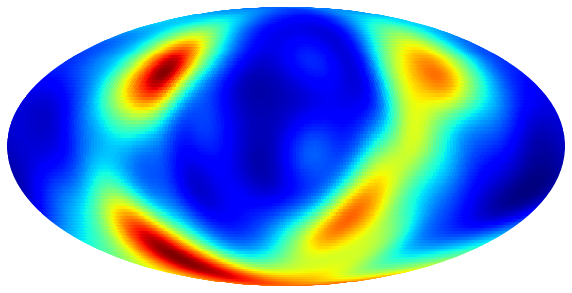

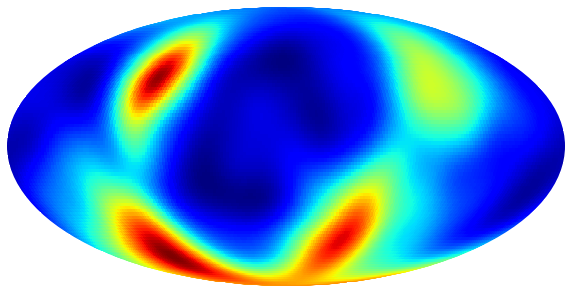

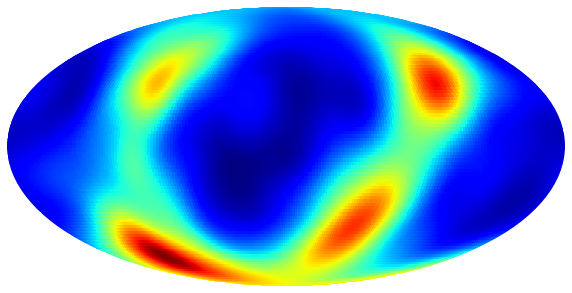

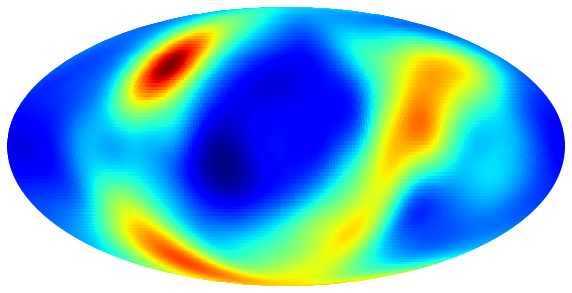

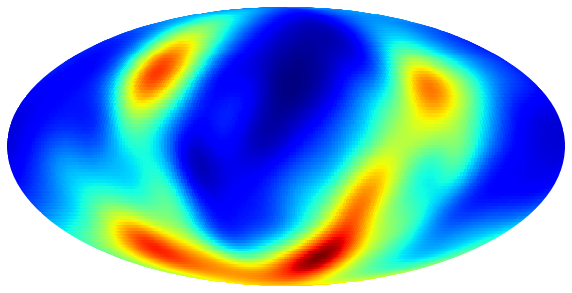

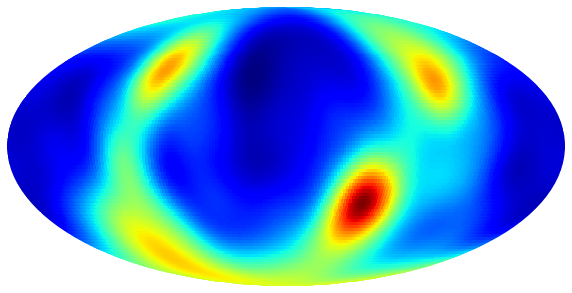

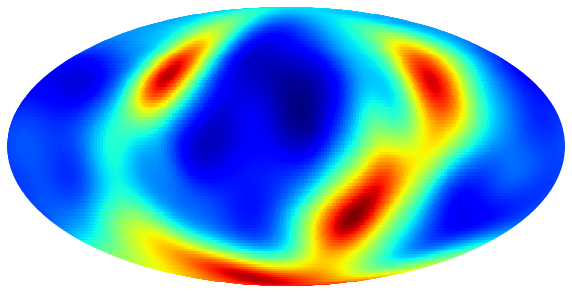

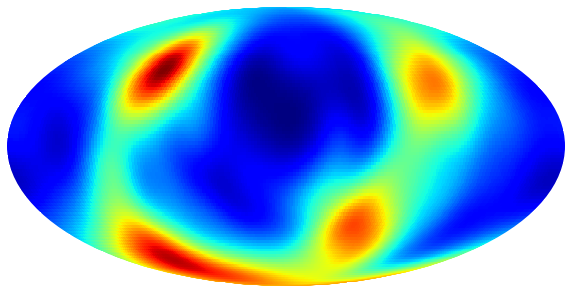

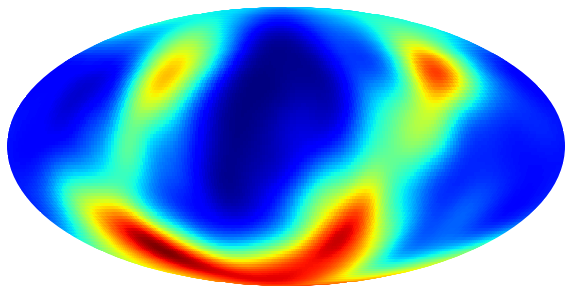

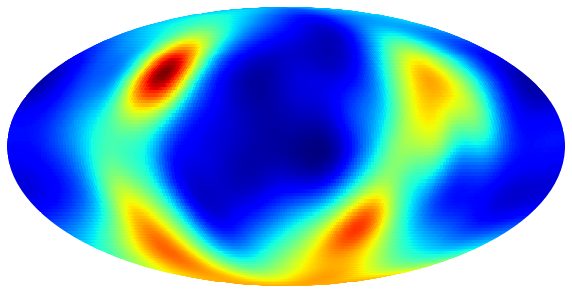

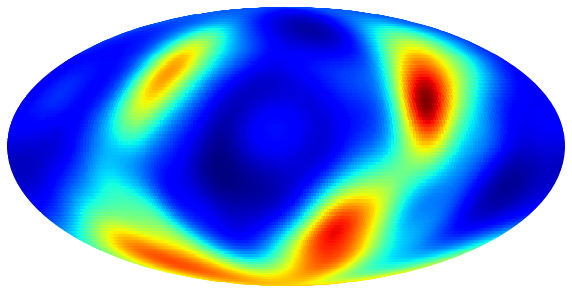

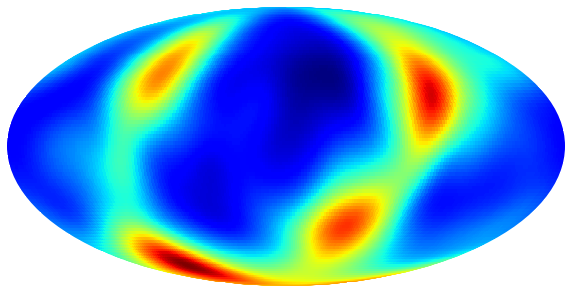

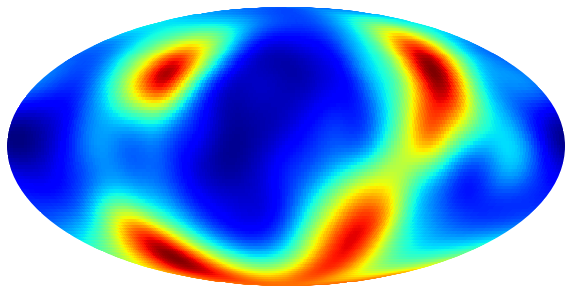

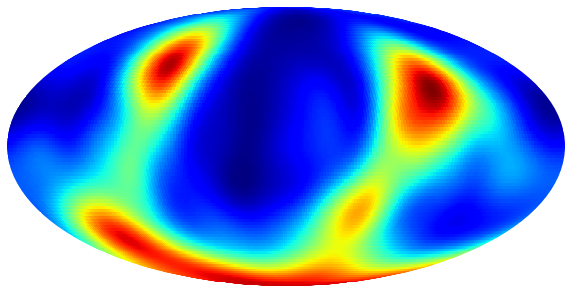

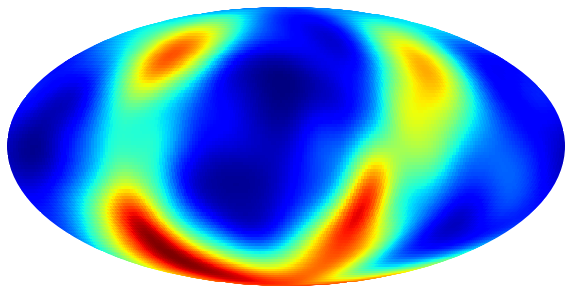

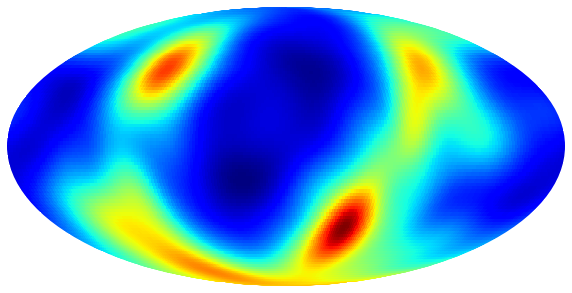

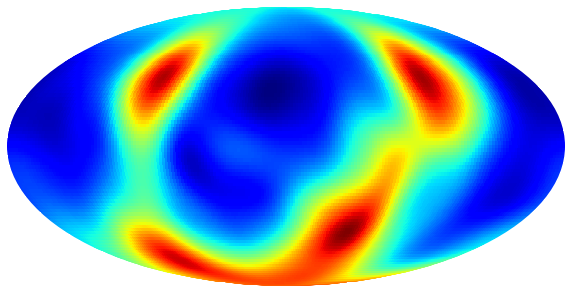

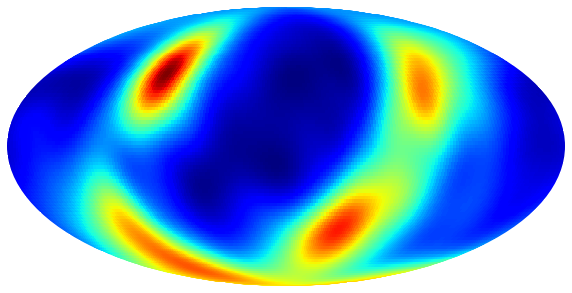

In [42]:
for k in range(len(L)):
    ## Gaussian KDE as in "NF on Tori and Spheres"
    noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
    z0, _ = L[k](noise)

    kernel = gaussian_kde(z0[-1].T.detach().cpu())


    fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
    projection_mollweide(lambda x: kernel.pdf(x.T), ax)
    plt.show()

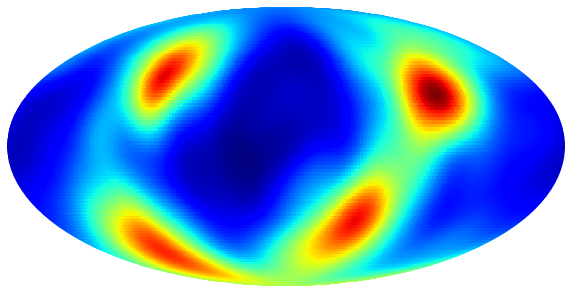

In [43]:
## Gaussian KDE as in "NF on Tori and Spheres"
noise = F.normalize(torch.randn((1000,3), device=device), p=2, dim=-1)
z0, _ = L[-1](noise)

kernel = gaussian_kde(z0[-1].T.detach().cpu())


fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
projection_mollweide(lambda x: kernel.pdf(x.T), ax)
plt.show()